In [1]:
import pickle
import os
import time
import numpy as np
import ast

import polychrom

from polychrom.hdf5_format import HDF5Reporter, list_URIs, load_URI, load_hdf5_file
import polychrom.contactmaps

import cooltools
import cooltools.lib.plotting

import pandas as pd
import warnings
import h5py 
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from polychrom.polymer_analyses import slope_contact_scaling
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
from scipy.optimize import fsolve

/home1/rahmanin/.conda/envs/openwpoly/lib/python3.7/site-packages/cooltools/lib/numutils.py:11: FutureWarning: The `cooler.tools` module is deprecated in v0.9 and will be removed in v0.10. Use `cooler.parallel` instead.
  from ._numutils import (
/home1/rahmanin/.conda/envs/openwpoly/lib/python3.7/site-packages/cooltools/api/expected.py:14: FutureWarning: The `cooler.tools` module is deprecated in v0.9 and will be removed in v0.10. Use `cooler.parallel` instead.
  from cooler.tools import partition


### making dictionary of trajectories

In [3]:
path_dict = {}

directory = '/project/fudenber_735/polychrom/Dynamic_boundary_model/3d_sims_dynamic_boundary/layout_random/'
#directory = '../sims/'
for name  in glob.glob(directory+'sims/folder_*'):
    path_dict[name.split('/sims/')[1][:]]= name
path_dict = dict(sorted(path_dict.items()))

### function for calculating P(s)

In [4]:
resolution = 2500
mapN = 3000
bins = np.array(cooltools.numutils.logbins(3, mapN-500 , N=34)) 
binmids = .5*(bins[:-1]+bins[1:]) *resolution

def doScaling(bins,heatmap,distmap,mask):
    h = heatmap[mask]; d = distmap[mask]
    inds = np.argsort(d)
    h=h[inds]; d=d[inds]; p = np.zeros(len(bins)-1,)
    binlocs = np.searchsorted(d,bins,'left')
    binnedObs = []; binnedExp = []
    for j in range(len(binlocs)-1):
        binnedObs.append(np.sum(h[binlocs[j]:binlocs[j+1]]))
        binnedExp.append(len(d[binlocs[j]:binlocs[j+1]]))
        if binlocs[j+1]-binlocs[j] != len(d[binlocs[j]:binlocs[j+1]]):   asdf
    binnedObs = np.array(binnedObs)
    binnedExp = np.array(binnedExp)
    return binnedObs, binnedExp

### Saving contact frequency vs distance

skip this step if p_s data is saved

In [5]:
for name in path_dict.keys():
    params=[ast.literal_eval(i) for i in name.split('folder_')[1].split('_')[1::2]]
    face, back, clife, cof, life, slife, birth, pause, sep, site, mon, rep, step, vel = params
    data = np.load(directory + 'data/maps/%s.npz' % name)
    mrc=data['arr_0']
    mrc  = mrc.astype(float)
    mrc /= np.median(np.diag(mrc,2))
    distmap = np.abs (np.arange(len(mrc))[:,None]-np.arange(len(mrc))[None,:])
    o, e = doScaling(bins, mrc, distmap, distmap>0)
    np.savetxt(directory + 'data/p_s/%s.dat'%name, np.c_[binmids,o/e])

### analysis for various binding time 

color scale definition

In [6]:
num_plot =5
viridis_cmap = plt.get_cmap('cividis')

# Generate an array of values from 0 to 1 to map to colors in the colormap
values = np.linspace(0, 1, num_plot)

# Get the corresponding colors from the colormap
colors = viridis_cmap(values)

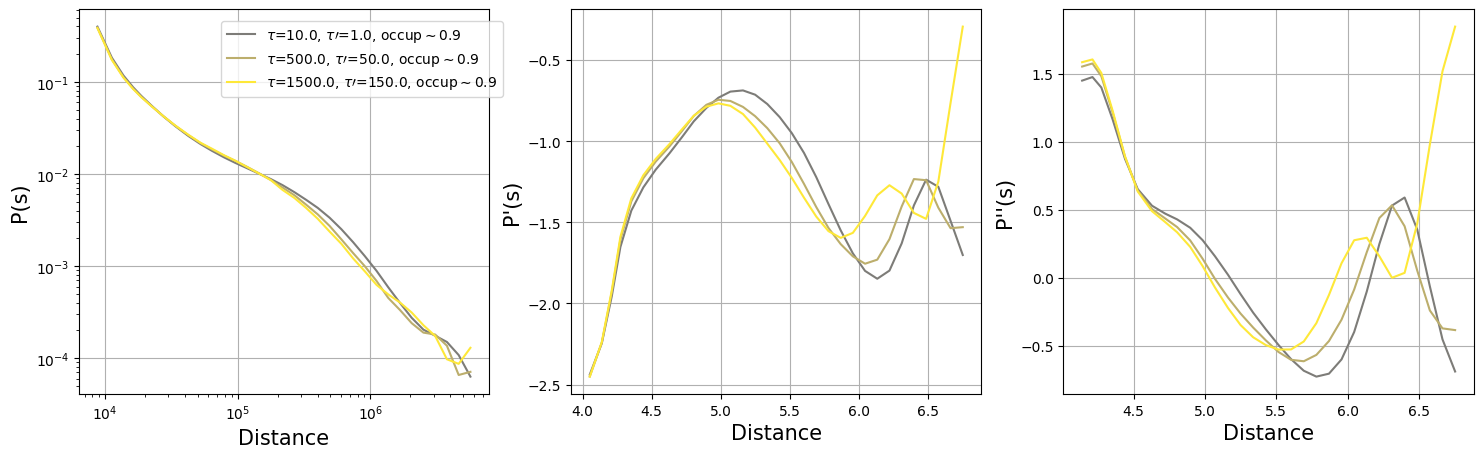

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 3 rows, 1 column
i= 1
peak_locs = []
peak_widths = []
peak_heights = []
clife_range = [ 10, 500,  1500]

name = list(path_dict.keys())[1]
data = np.load(directory + 'data/maps/%s.npz' % name)
mrc = data['arr_0']

distmap = np.abs(np.arange(len(mrc))[:,None]-np.arange(len(mrc))[None,:])
for clife_val in clife_range:
    i +=1
    for name in path_dict.keys():
        params=[ast.literal_eval(i) for i in name.split('folder_')[1].split('_')[1::2]]
        face, back, clife, cof, life, slife, birth, pause, sep, site, mon, rep, step, vel = params
        data = np.loadtxt(directory + 'data/p_s/%s.dat'%name)
        contact_freq = data[:,1]
        distance = data[:,0]
        s, der = slope_contact_scaling(distance, contact_freq, sigma=1.5)
        sp,derp=slope_contact_scaling(s, np.exp(der),sigma=1.5)
        x = np.linspace(np.min(np.log10(s)),np.max(np.log10(s)),len(s))
        y=np.array([-1.25]*len(x))

        if clife==clife_val:
            if life == 500 and vel ==1 and clife ==10*cof:
                peaks = find_peaks(der)
                peak_locs.append(s[peaks[0][0]])
                # obtaining index of intersection to compute width of peaks
                idx = np.argwhere(np.diff(np.sign(y-der))).flatten()
                idxs = np.array([5,idx[1]])
                peak_widths.append(s[idxs][1]-s[idxs][0])
                peak_heights.append(der[peaks[0][0]])
                axs[1].plot(np.log10(s), der, label=r'$\tau$=%s, $\tau\prime$=%s, occup$\sim$0.9'%(clife,cof),color = colors[i])
                axs[0].loglog(distance, contact_freq, label=r'$\tau$=%s, $\tau\prime$=%s, occup$\sim$0.9'%(clife,cof),color = colors[i])
                axs[2].plot(np.log10(sp), derp, label=r'$\tau$=%s, $\tau\prime$=%s, occup$\sim$0.9'%(clife,cof),color = colors[i])
axs[1].set_ylabel('P\'(s)', fontsize = 15)
axs[2].set_ylabel('P\'\'(s)', fontsize = 15)
axs[0].set_ylabel('P(s)', fontsize = 15)
for ax in axs:
    ax.grid(True)
    ax.set_xlabel('Distance', fontsize = 15)
plt.savefig('pos_for_bindingtime.png')
axs[0].legend( bbox_to_anchor=(1.05, 0.87),loc='right')
plt.show()

### P'(s)

[ 5 19]
[ 5 17]
[ 4 17 28]


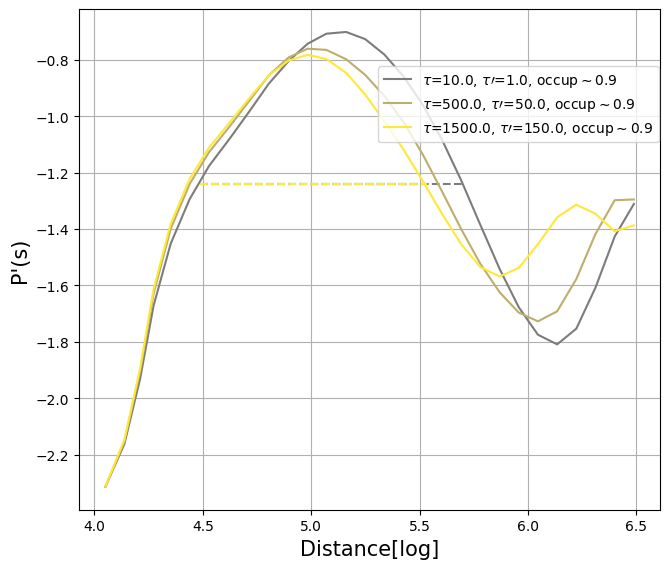

In [40]:
plt.figure(figsize=(7.5, 6.5))

i= 1
peak_locs = []
peak_widths = []
peak_heights = []
clife_range = [ 10, 500, 1500]
for clife_val in clife_range:
    i +=1
    for name in path_dict.keys():
        params=[ast.literal_eval(i) for i in name.split('folder_')[1].split('_')[1::2]]
        face, back, clife, cof, life, slife, birth, pause, sep, site, mon, rep, step, vel = params
        data = np.loadtxt(directory + 'data/p_s/%s.dat'%name)
        contact_freq = data[:,1]
        distance = data[:,0]
        s, der = slope_contact_scaling(distance, contact_freq, sigma=1.75)
        x = np.linspace(np.min(np.log10(s)),np.max(np.log10(s)),len(s))
        y=np.array([-1.240]*len(x))
        
        if clife==clife_val:
            if life == 500 and vel ==1 and clife ==10*cof:
                peaks = find_peaks(der)
                peak_locs.append(s[peaks[0][0]])
                
                # obtaining index of intersection to compute width of peaks
                idx = np.argwhere(np.diff(np.sign(y-der))).flatten()
                print(idx)
                idxs = np.array([5,idx[1]])
                peak_widths.append(s[idxs][1]-s[idxs][0])
                peak_heights.append(der[peaks[0][0]])
                plt.plot(((x[idxs])), y[idxs],color= colors[i],linestyle='--')
                plt.plot(np.log10(s[:-3]), der[:-3], label=r'$\tau$=%s, $\tau\prime$=%s, occup$\sim$0.9'%(clife,cof),color = colors[i])
plt.grid(True)
plt.xlabel('Distance[log]', fontsize = 15)
plt.ylabel('P\'(s)', fontsize = 15)
plt.legend( bbox_to_anchor=(1.01, 0.81),loc='right')
plt.savefig('contact_freq_derivative.png')
plt.show()

### higher processivity investigation; lifetime

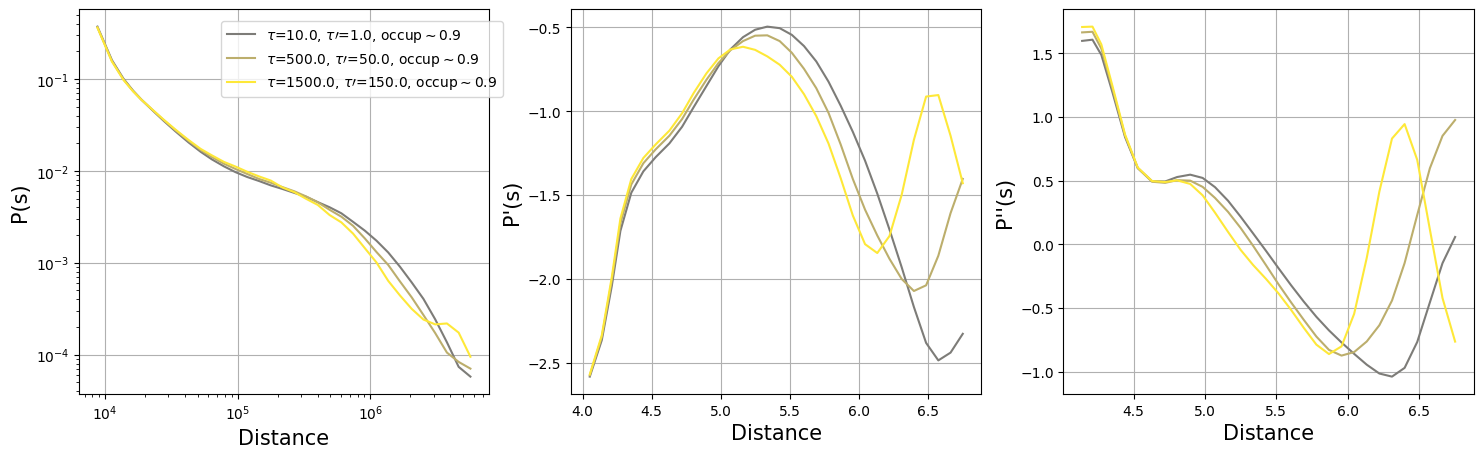

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 3 rows, 1 column
distmap =    np.abs(np.arange(len(mrc))[:,None]-np.arange(len(mrc))[None,:])
i= 1
peak_locs_life = []
peak_widths_life = []
peak_heights_life = []
clife_range = [ 10, 500,  1500]
for clife_val in clife_range:
    i +=1
    for name in path_dict.keys():
        params=[ast.literal_eval(i) for i in name.split('folder_')[1].split('_')[1::2]]
        face, back, clife, cof, life, slife, birth, pause, sep, site, mon, rep, step, vel = params
        data = np.loadtxt(directory + 'data/p_s/%s.dat'%name)
        contact_freq = data[:,1]
        distance = data[:,0]
        s, der = slope_contact_scaling(distance, contact_freq, sigma=1.5)
        sp,derp=slope_contact_scaling(s, np.exp(der),sigma=1.5)
        x = np.linspace(np.min(np.log10(s)),np.max(np.log10(s)),len(s))
        y=np.array([-1.25]*len(x))

        if clife==clife_val:
            if life == 1500 and vel ==1 and clife ==10*cof:
                peaks = find_peaks(der)
                peak_locs_life.append(s[peaks[0][0]])
                # obtaining index of intersection to compute width of peaks
                idx = np.argwhere(np.diff(np.sign(y-der))).flatten()
                idxs = np.array([5,idx[1]])
                peak_widths_life.append(s[idxs][1]-s[idxs][0])
                peak_heights_life.append(der[peaks[0][0]])
                axs[1].plot(np.log10(s), der, label=r'$\tau$=%s, $\tau\prime$=%s, occup$\sim$0.9'%(clife,cof),color = colors[i])
                axs[0].loglog(distance, contact_freq, label=r'$\tau$=%s, $\tau\prime$=%s, occup$\sim$0.9'%(clife,cof),color = colors[i])
                axs[2].plot(np.log10(sp), derp, label=r'$\tau$=%s, $\tau\prime$=%s, occup$\sim$0.9'%(clife,cof),color = colors[i])
axs[1].set_ylabel('P\'(s)', fontsize = 15)
axs[2].set_ylabel('P\'\'(s)', fontsize = 15)
axs[0].set_ylabel('P(s)', fontsize = 15)
for ax in axs:
    ax.grid(True)
    ax.set_xlabel('Distance', fontsize = 15)
plt.savefig('pos_for_lifetime.png')
axs[0].legend( bbox_to_anchor=(1.05, 0.87),loc='right')
plt.show()

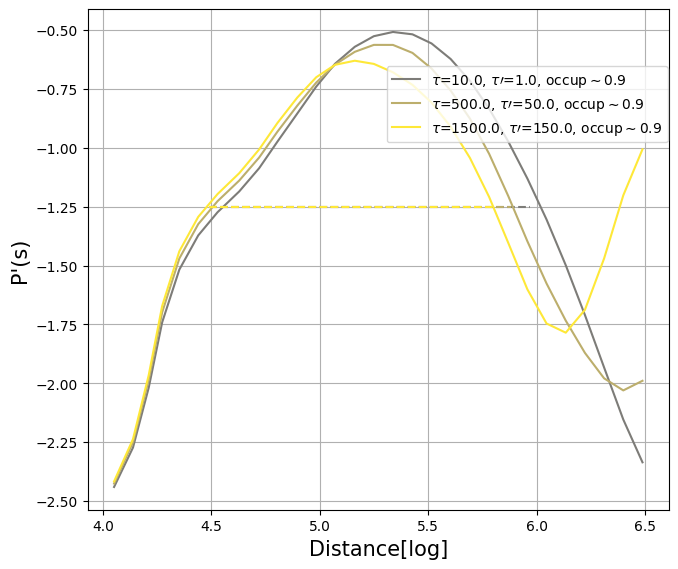

In [16]:
plt.figure(figsize=(7.5, 6.5))

i= 1
peak_locs_life = []
peak_widths_life = []
peak_heights_life = []
clife_range = [ 10, 500,  1500]
for clife_val in clife_range:
    i +=1
    for name in path_dict.keys():
        params=[ast.literal_eval(i) for i in name.split('folder_')[1].split('_')[1::2]]
        face, back, clife, cof, life, slife, birth, pause, sep, site, mon, rep, step, vel = params
        data = np.loadtxt(directory + 'data/p_s/%s.dat'%name)
        contact_freq = data[:,1]
        distance = data[:,0]
        s, der = slope_contact_scaling(distance, contact_freq, sigma=1.75)
        x = np.linspace(np.min(np.log10(s)),np.max(np.log10(s)),len(s))
        y=np.array([-1.25]*len(x))
        
        if clife==clife_val:
            if life == 1500 and vel ==1 and clife ==10*cof:
                peaks = find_peaks(der)
                peak_locs_life.append(s[peaks[0][0]])
                
                # obtaining index of intersection to compute width of peaks
                idx = np.argwhere(np.diff(np.sign(y-der))).flatten()
                idxs = np.array([5,idx[1]])
                peak_widths_life.append(s[idxs][1]-s[idxs][0])
                peak_heights_life.append(der[peaks[0][0]])
                plt.plot(((x[idxs])), y[idxs],color= colors[i],linestyle='--')
                plt.plot(np.log10(s[:-3]), der[:-3], label=r'$\tau$=%s, $\tau\prime$=%s, occup$\sim$0.9'%(clife,cof),color = colors[i])
plt.grid(True)
plt.xlabel('Distance[log]', fontsize = 15)
plt.ylabel('P\'(s)', fontsize = 15)
plt.legend( bbox_to_anchor=(1.01, 0.81),loc='right')
#plt.savefig('contact_freq_derivative.png')
plt.show()

### velocity 

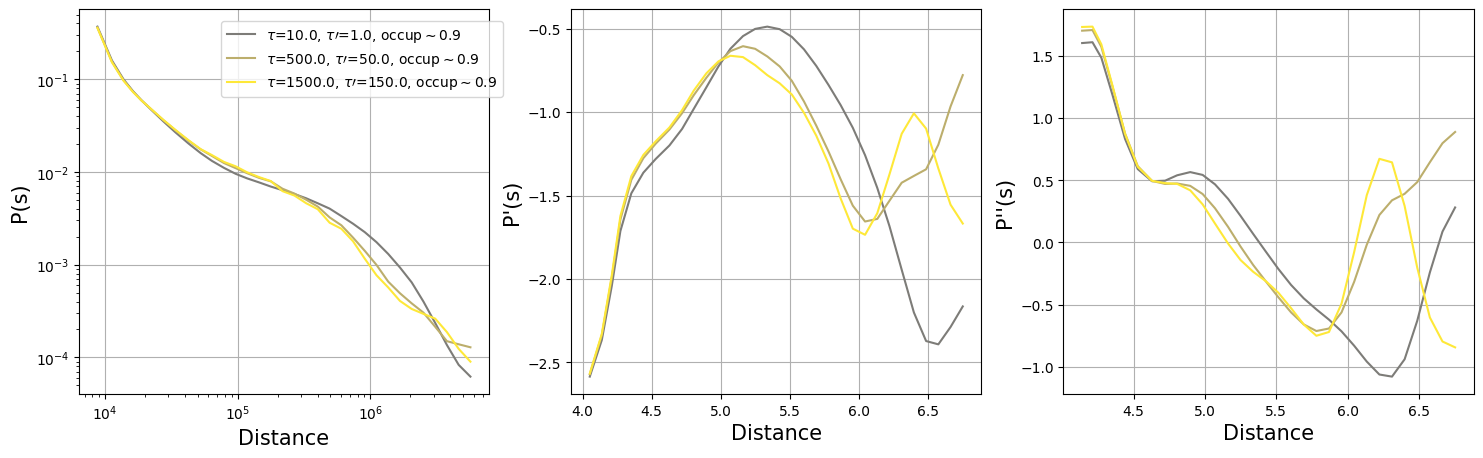

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 3 rows, 1 column
distmap =    np.abs(np.arange(len(mrc))[:,None]-np.arange(len(mrc))[None,:])
i= 1
peak_locs_vel = []
peak_widths_vel = []
peak_heights_vel = []
clife_range = [ 10, 500,  1500]
for clife_val in clife_range:
    i +=1
    for name in path_dict.keys():
        params=[ast.literal_eval(i) for i in name.split('folder_')[1].split('_')[1::2]]
        face, back, clife, cof, life, slife, birth, pause, sep, site, mon, rep, step, vel = params
        data = np.loadtxt(directory + 'data/p_s/%s.dat'%name)
        contact_freq = data[:,1]
        distance = data[:,0]
        s, der = slope_contact_scaling(distance, contact_freq, sigma=1.5)
        sp,derp=slope_contact_scaling(s, np.exp(der),sigma=1.5)
        x = np.linspace(np.min(np.log10(s)),np.max(np.log10(s)),len(s))
        y=np.array([-1.25]*len(x))

        if clife==clife_val:
            if life == 500 and vel ==3 and clife ==10*cof:
                peaks = find_peaks(der)
                peak_locs_vel.append(s[peaks[0][0]])
                # obtaining index of intersection to compute width of peaks
                idx = np.argwhere(np.diff(np.sign(y-der))).flatten()
                idxs = np.array([5,idx[1]])
                peak_widths_vel.append(s[idxs][1]-s[idxs][0])
                peak_heights_vel.append(der[peaks[0][0]])
                axs[1].plot(np.log10(s), der, label=r'$\tau$=%s, $\tau\prime$=%s, occup$\sim$0.9'%(clife,cof),color = colors[i])
                axs[0].loglog(distance, contact_freq, label=r'$\tau$=%s, $\tau\prime$=%s, occup$\sim$0.9'%(clife,cof),color = colors[i])
                axs[2].plot(np.log10(sp), derp, label=r'$\tau$=%s, $\tau\prime$=%s, occup$\sim$0.9'%(clife,cof),color = colors[i])
axs[1].set_ylabel('P\'(s)', fontsize = 15)
axs[2].set_ylabel('P\'\'(s)', fontsize = 15)
axs[0].set_ylabel('P(s)', fontsize = 15)
for ax in axs:
    ax.grid(True)
    ax.set_xlabel('Distance', fontsize = 15)
plt.savefig('pos_for_velocity.png')
axs[0].legend( bbox_to_anchor=(1.05, 0.87),loc='right')
plt.show()

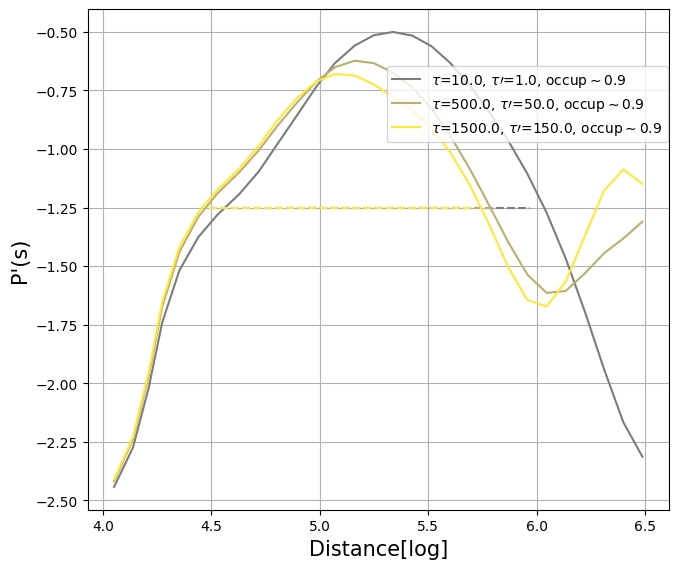

In [18]:
plt.figure(figsize=(7.5, 6.5))

i= 1
peak_locs_vel = []
peak_widths_vel = []
peak_heights_vel = []
clife_range = [ 10, 500,  1500]
for clife_val in clife_range:
    i +=1
    for name in path_dict.keys():
        params=[ast.literal_eval(i) for i in name.split('folder_')[1].split('_')[1::2]]
        face, back, clife, cof, life, slife, birth, pause, sep, site, mon, rep, step, vel = params
        data = np.loadtxt(directory + 'data/p_s/%s.dat'%name)
        contact_freq = data[:,1]
        distance = data[:,0]
        s, der = slope_contact_scaling(distance, contact_freq, sigma=1.75)
        x = np.linspace(np.min(np.log10(s)),np.max(np.log10(s)),len(s))
        y=np.array([-1.25]*len(x))
        
        if clife==clife_val:
            if life == 500 and vel ==3 and clife ==10*cof:
                peaks = find_peaks(der)
                peak_locs_vel.append(s[peaks[0][0]])
                
                # obtaining index of intersection to compute width of peaks
                idx = np.argwhere(np.diff(np.sign(y-der))).flatten()
                idxs = np.array([5,idx[1]])
                peak_widths_vel.append(s[idxs][1]-s[idxs][0])
                peak_heights_vel.append(der[peaks[0][0]])
                plt.plot(((x[idxs])), y[idxs],color= colors[i],linestyle='--')
                plt.plot(np.log10(s[:-3]), der[:-3], label=r'$\tau$=%s, $\tau\prime$=%s, occup$\sim$0.9'%(clife,cof),color = colors[i])
plt.grid(True)
plt.xlabel('Distance[log]', fontsize = 15)
plt.ylabel('P\'(s)', fontsize = 15)
plt.legend( bbox_to_anchor=(1.01, 0.81),loc='right')
#plt.savefig('contact_freq_derivative.png')
plt.show()

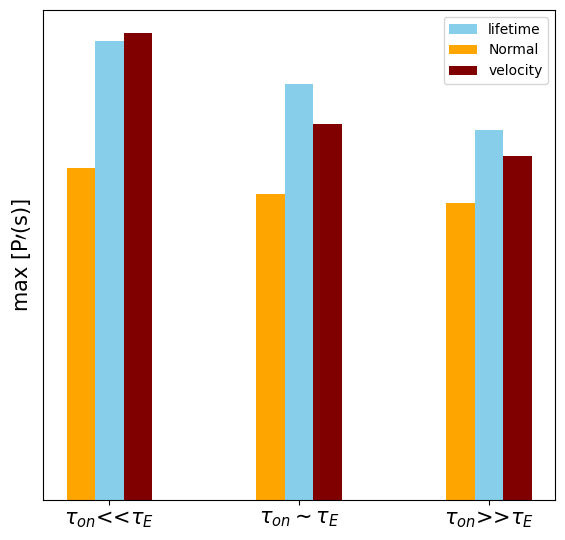

In [19]:
fig, ax = plt.subplots(figsize=(5.75, 5.5)) 

m =np.max(peak_heights+peak_heights_life+peak_heights_vel)
bar_width = 0.15  
index = np.arange(len(cases)) 

ax.bar(index  , m/peak_heights_life, bar_width, label='lifetime', color='skyblue')
ax.bar(index-bar_width , m/peak_heights, bar_width, label='Normal', color='orange')
ax.bar(index + bar_width, m/peak_heights_vel, bar_width, label='velocity', color ='maroon')

ax.set_ylabel(r'max [P$\prime$(s)]', fontsize = 15)
ax.set_xticks(index)
ax.set_xticklabels(cases,fontsize=15)
ax.legend()
ax.set_yticks([])

plt.tight_layout()
plt.savefig('peak.png')
plt.show()


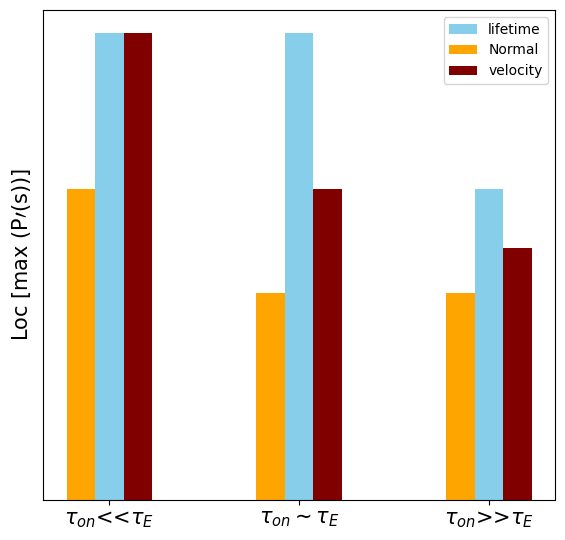

In [18]:
fig, ax = plt.subplots(figsize=(5.75, 5.5)) 

cases = [r'$\tau_{on}$<<$\tau_E$',r'$\tau_{on}\sim\tau_E$',r'$\tau_{on}$>>$\tau_E$']
m =np.max(peak_heights+peak_heights_life+peak_heights_vel)
bar_width = 0.15  
index = np.arange(len(cases)) 

ax.bar(index  , peak_locs_life, bar_width, label='lifetime', color='skyblue')
ax.bar(index-bar_width , peak_locs, bar_width, label='Normal', color='orange')
ax.bar(index + bar_width, peak_locs_vel, bar_width, label='velocity', color ='maroon')

ax.set_ylabel(r'Loc [max (P$\prime$(s))]', fontsize = 15)
ax.set_xticks(index)
ax.set_xticklabels(cases,fontsize=15)
ax.legend()
ax.set_yticks([])

plt.tight_layout()
plt.savefig('peak_loc.png')
plt.show()

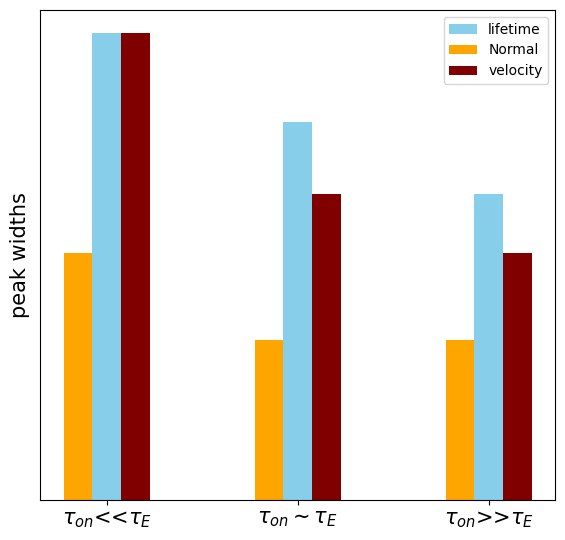

In [20]:
fig, ax = plt.subplots(figsize=(5.75, 5.5)) 

bar_width = 0.15  
index = np.arange(len(cases)) 

ax.bar(index  , peak_widths_life, bar_width, label='lifetime', color='skyblue')
ax.bar(index-bar_width , peak_widths, bar_width, label='Normal', color='orange')
ax.bar(index + bar_width, peak_widths_vel, bar_width, label='velocity', color ='maroon')

ax.set_ylabel(r'peak widths', fontsize = 15)
ax.set_xticks(index)
ax.set_xticklabels(cases,fontsize=15)
ax.legend()
ax.set_yticks([])

plt.tight_layout()
plt.savefig('peak_widths.png')
plt.show()